# Decision Tree construction

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
import pandas as pd

%load_ext autoreload
%autoreload 2

Let's fix the `random_state` (a.k.a. random seed).

In [2]:
RANDOM_STATE = 42

__Your ultimate task for today is to impement the `DecisionTree` class and use it to solve classification and regression problems.__

## __Specifications:__
- The class inherits from `sklearn.BaseEstimator`;
- Constructor is implemented for you. It has the following parameters:
    * `max_depth` - maximum depth of the tree; `np.inf` by default
    * `min_samples_split` - minimal number of samples in the leaf to make a split; `2` by default;
    * `criterion` - criterion to select the best split; in classification one of `['gini', 'entropy']`, default `gini`; in regression `variance`;

- `fit` method takes `X` (`numpy.array` of type `float` shaped `(n_objects, n_features)`) and `y` (`numpy.array` of type float shaped `(n_objects, 1)` in regression; `numpy.array` of type int shaped `(n_objects, 1)` with class labels in classification). It works inplace and fits the `DecisionTree` class instance to the provided data from scratch.

- `predict` method takes `X` (`numpy.array` of type `float` shaped `(n_objects, n_features)`) and returns the predicted $\hat{y}$ values. In classification it is a class label for every object (the most frequent in the leaf; if several classes meet this requirement select the one with the smallest class index). In regression it is the desired constant (e.g. mean value for `variance` criterion)

- `predict_proba` method (works only for classification (`gini` or `entropy` criterion). It takes `X` (`numpy.array` of type `float` shaped `(n_objects, n_features)`) and returns the `numpy.array` of type `float` shaped `(n_objects, n_features)` with class probabilities for every object from `X`. Class $i$ probability equals the ratio of $i$ class objects that got in this node in the training set.

## __Small recap:__

To find the optimal split the following functional is evaluated:
    
$$G(j, t) = H(Q) - \dfrac{|L|}{|Q|} H(L) - \dfrac{|R|}{|Q|} H(R),$$
    where $Q$ is the dataset from the current node, $L$ and $R$ are left and right subsets defined by the split $x^{(j)} < t$.



1. Classification. Let $p_i$ be the probability of $i$ class in subset $X$ (ratio of the $i$ class objects in the dataset). The criterions are defined as:
    
    * `gini`: Gini impurity $$H(R) = 1 -\sum_{i = 1}^K p_i^2$$
    
    * `entropy`: Entropy $$H(R) = -\sum_{i = 1}^K p_i \log(p_i)$$ (One might use the natural logarithm).
    
2. Regression. Let $y_l$ be the target value for the $R$, $\mathbf{y} = (y_1, \dots, y_N)$ – all targets for the selected dataset $X$.
    
    * `variance`: $$H(R) = \dfrac{1}{|R|} \sum_{y_j \in R}(y_j - \text{mean}(\mathbf{y}))^2$$
    
    * `mad_median`: $$H(R) = \dfrac{1}{|R|} \sum_{y_j \in R}|y_j - \text{median}(\mathbf{y})|$$
        


**Hints and comments**:

* No need to deal with categorical features, they will not be present.
* Siple greedy recursive procedure is enough. However, you can speed it up somehow (e.g. using percentiles).
* Please, do not copy implementations available online. You are supposed to build very simple example of the Decision Tree.

## __Realisation__

In [3]:
def entropy(y):  
    """
    Computes entropy of the provided distribution. Use log(value + eps) for numerical stability
    
    Parameters
    ----------
    y : np.array of type float with shape (n_objects, n_classes)
        One-hot representation of class labels for corresponding subset
    
    Returns
    -------
    float
        Entropy of the provided subset
    """
    EPS = 0.0005

    # YOUR CODE HERE
    n_objects, n_class = y.shape
    p = sum(y) / n_objects
    
    entropy = -sum(p * np.log(p + EPS))
    
    return entropy

In [4]:
def gini(y):
    """
    Computes the Gini impurity of the provided distribution
    
    Parameters
    ----------
    y : np.array of type float with shape (n_objects, n_classes)
        One-hot representation of class labels for corresponding subset
    
    Returns
    -------
    float
        Gini impurity of the provided subset
    """

    # YOUR CODE HERE
    n_objects, n_class = y.shape
    p = sum(y) / n_objects
    gini = 1 - sum(p**2)
    
    return gini

In [5]:
def variance(y):
    """
    Computes the variance the provided target values subset
    
    Parameters
    ----------
    y : np.array of type float with shape (n_objects, 1)
        Target values vector
    
    Returns
    -------
    float
        Variance of the provided target vector
    """
    
    # YOUR CODE HERE
    
    variance = 1 / len(y) * sum((y - np.mean(y))**2)
    
    return variance


In [6]:
def mad_median(y):
    """
    Computes the mean absolute deviation from the median in the
    provided target values subset
    
    Parameters
    ----------
    y : np.array of type float with shape (n_objects, 1)
        Target values vector
    
    Returns
    -------
    float
        Mean absolute deviation from the median in the provided vector
    """

    # YOUR CODE HERE
    
    mad_median = 1 / len(y) * sum(abs(y - np.median(y)))
    
    return mad_median

In [7]:
def one_hot_encode(n_classes, y):
    y_one_hot = np.zeros((len(y), n_classes), dtype=float)
    y_one_hot[np.arange(len(y)), y.astype(int)[:, 0]] = 1.
    return y_one_hot

In [8]:
def one_hot_decode(y_one_hot):
    return y_one_hot.argmax(axis=1)[:, None]

In [9]:
class Node:
    """
    This class is provided "as is" and it is not mandatory to it use in your code.
    """
    def __init__(self, feature_index, threshold, proba=0):
        self.feature_index = feature_index
        self.value = threshold
        self.proba = proba
        self.left_child = None
        self.right_child = None

In [10]:
class DecisionTree(BaseEstimator):
    all_criterions = {
        'gini': (gini, True), # (criterion, classification flag)
        'entropy': (entropy, True),
        'variance': (variance, False),
        'mad_median': (mad_median, False)
    }

    def __init__(self, n_classes=None, max_depth=np.inf, min_samples_split=2, 
                 criterion_name='gini', debug=False):

        assert criterion_name in self.all_criterions.keys(), 'Criterion name must be on of the following: {}'.format(self.all_criterions.keys())
        
        self.n_classes = n_classes
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion_name = criterion_name

        self.depth = 0
        self.root = None # Use the Node class to initialize it later
        self.debug = debug

        
        
    def make_split(self, feature_index, threshold, X_subset, y_subset):
        """
        Makes split of the provided data subset and target values using provided feature and threshold
        
        Parameters
        ----------
        feature_index : int
            Index of feature to make split with

        threshold : float
            Threshold value to perform split

        X_subset : np.array of type float with shape (n_objects, n_features)
            Feature matrix representing the selected subset

        y_subset : np.array of type float with shape (n_objects, n_classes) in classification 
                   (n_objects, 1) in regression 
            One-hot representation of class labels for corresponding subset
        
        Returns
        -------
        (X_left, y_left) : tuple of np.arrays of same type as input X_subset and y_subset
            Part of the providev subset where selected feature x^j < threshold
        (X_right, y_right) : tuple of np.arrays of same type as input X_subset and y_subset
            Part of the providev subset where selected feature x^j >= threshold
        """

        # YOUR CODE HERE
        left = X_subset[:, feature_index] < threshold
        right = X_subset[:, feature_index] >= threshold
        
        X_left, y_left = X_subset[left], y_subset[left]
        X_right, y_right = X_subset[right], y_subset[right]
        
        return (X_left, y_left), (X_right, y_right)
    
    def make_split_only_y(self, feature_index, threshold, X_subset, y_subset):
        """
        Split only target values into two subsets with specified feature and threshold
        
        Parameters
        ----------
        feature_index : int
            Index of feature to make split with

        threshold : float
            Threshold value to perform split

        X_subset : np.array of type float with shape (n_objects, n_features)
            Feature matrix representing the selected subset

        y_subset : np.array of type float with shape (n_objects, n_classes) in classification 
                   (n_objects, 1) in regression 
            One-hot representation of class labels for corresponding subset
        
        Returns
        -------
        y_left : np.array of type float with shape (n_objects_left, n_classes) in classification 
                   (n_objects, 1) in regression 
            Part of the provided subset where selected feature x^j < threshold

        y_right : np.array of type float with shape (n_objects_right, n_classes) in classification 
                   (n_objects, 1) in regression 
            Part of the provided subset where selected feature x^j >= threshold
        """

        # YOUR CODE HERE
        
        left = X_subset[:, feature_index] < threshold
        right = X_subset[:, feature_index] >= threshold
        
        y_left = y_subset[left]
        y_right = y_subset[right]
        
        return y_left, y_right

    def choose_best_split(self, X_subset, y_subset):
        """
        Greedily select the best feature and best threshold w.r.t. selected criterion
        
        Parameters
        ----------
        X_subset : np.array of type float with shape (n_objects, n_features)
            Feature matrix representing the selected subset

        y_subset : np.array of type float with shape (n_objects, n_classes) in classification 
                   (n_objects, 1) in regression 
            One-hot representation of class labels or target values for corresponding subset
        
        Returns
        -------
        feature_index : int
            Index of feature to make split with

        threshold : float
            Threshold value to perform split

        """
        # YOUR CODE HERE
        
        gain_best = np.inf
        feature_index = 0
        threshold = 0
        
        
        n_objects, n_features = X_subset.shape
        H = self.all_criterions[self.criterion_name][0]
        
        for index_tmp in range(n_features):
            for threshold_tmp in X_subset[:, index_tmp]:
                y_left, y_right = self.make_split_only_y(index_tmp, threshold_tmp, X_subset, y_subset)
                if(len(y_left) * len(y_right) == 0): 
                    gain = np.inf
                else:
                    gain = len(y_left) / n_objects * H(y_left) + len(y_right) / n_objects * H(y_right)
                    if gain_best > gain:
                        gain_best = gain
                        feature_index, threshold = index_tmp, threshold_tmp
                
        return feature_index, threshold
    
    def make_tree(self, X_subset, y_subset, depth):
        """
        Recursively builds the tree
        
        Parameters
        ----------
        X_subset : np.array of type float with shape (n_objects, n_features)
            Feature matrix representing the selected subset

        y_subset : np.array of type float with shape (n_objects, n_classes) in classification 
                   (n_objects, 1) in regression 
            One-hot representation of class labels or target values for corresponding subset
        
        Returns
        -------
        root_node : Node class instance
            Node of the root of the fitted tree
        """

        # YOUR CODE HERE
        feature_index, threshold = self.choose_best_split(X_subset, y_subset)
        n_objects = len(y_subset)
        
        if self.criterion:    
            proba = np.sum(y_subset, axis=0) / n_objects
            
        else:
            proba = np.mean(y_subset)
        
        new_node = Node(feature_index, threshold, proba)
        
        if depth == self.max_depth or len(y_subset) <= self.min_samples_split:
            return new_node 
               
        (X_left, y_left), (X_right, y_right) = self.make_split(feature_index, threshold, X_subset, y_subset)
        
        
        new_node.left_child = self.make_tree(X_left, y_left,  depth + 1)
        new_node.right_child = self.make_tree(X_right, y_right,  depth + 1)
        
        
        return new_node
        
    def fit(self, X, y):
        """
        Fit the model from scratch using the provided data
        
        Parameters
        ----------
        X : np.array of type float with shape (n_objects, n_features)
            Feature matrix representing the data to train on

        y : np.array of type int with shape (n_objects, 1) in classification 
                   of type float with shape (n_objects, 1) in regression 
            Column vector of class labels in classification or target values in regression
        
        """
        assert len(y.shape) == 2 and len(y) == len(X), 'Wrong y shape'
        self.criterion, self.classification = self.all_criterions[self.criterion_name]
        if self.classification:
            if self.n_classes is None:
                self.n_classes = len(np.unique(y))
            y = one_hot_encode(self.n_classes, y)

        self.root = self.make_tree(X, y, 0)
    
    def predict(self, X):
        """
        Predict the target value or class label  the model from scratch using the provided data
        
        Parameters
        ----------
        X : np.array of type float with shape (n_objects, n_features)
            Feature matrix representing the data the predictions should be provided for

        Returns
        -------
        y_predicted : np.array of type int with shape (n_objects, 1) in classification 
                   (n_objects, 1) in regression 
            Column vector of class labels in classification or target values in regression
        
        """

        # YOUR CODE HERE
        
        def predict_one(x, node):
            if (node.left_child == None and node.right_child == None):
                return node.proba
            
            feature_index = node.feature_index
            threshold = node.value
            if (x[feature_index] < threshold): 
                return predict_one(x, node.left_child)
            else: 
                return predict_one(x, node.right_child)
        
        y_predicted = np.zeros(len(X))
        for i in range(len(X)):
            proba = predict_one(X[i,:], self.root)
            if self.classification:
                y_predicted[i] = proba.argmax()
            else:
                y_predicted[i] = proba
                
            
        
        return y_predicted
        
    def predict_proba(self, X):
        """
        Only for classification
        Predict the class probabilities using the provided data
        
        Parameters
        ----------
        X : np.array of type float with shape (n_objects, n_features)
            Feature matrix representing the data the predictions should be provided for

        Returns
        -------
        y_predicted_probs : np.array of type float with shape (n_objects, n_classes)
            Probabilities of each class for the provided objects
        
        """
        assert self.classification, 'Available only for classification problem'

        # YOUR CODE HERE
        def predict_one(x, node):
            if (node.left_child == None and node.right_child == None):
                return node.proba
            
            feature_index = node.feature_index
            threshold = node.value
            if (x[feature_index] < threshold): 
                return predict_one(x, node.left_child)
            else: 
                return predict_one(x, node.right_child)
        
        y_predicted_probs = []
        for i in range(len(X)):
            y_predicted_probs += [predict_one(X[i,:], self.root)]
            
        return np.array(y_predicted_probs)

## Simple check

In [11]:
X = np.ones((4, 5), dtype=float) * np.arange(4)[:, None]
y = np.arange(4)[:, None] + np.asarray([0.2, -0.3, 0.1, 0.4])[:, None]
class_estimator = DecisionTree(max_depth=10, criterion_name='gini')

(X_l, y_l), (X_r, y_r) = class_estimator.make_split(1, 1., X, y)

assert np.array_equal(X[:1], X_l)
assert np.array_equal(X[1:], X_r)
assert np.array_equal(y[:1], y_l)
assert np.array_equal(y[1:], y_r)

## Classification problem

In [12]:
digits_data = load_digits().data
digits_target = load_digits().target[:, None] # to make the targets consistent with our model interfaces
X_train, X_test, y_train, y_test = train_test_split(digits_data, digits_target, test_size=0.2, random_state=RANDOM_STATE)

In [13]:
assert len(y_train.shape) == 2 and y_train.shape[0] == len(X_train)

In [14]:
class_estimator = DecisionTree(max_depth=10, criterion_name='gini')
class_estimator.fit(X_train, y_train)
ans = class_estimator.predict(X_test)
accuracy_gini = accuracy_score(y_test, ans)
print(accuracy_gini)

0.8638888888888889


In [15]:
reference = np.array([0.09027778, 0.09236111, 0.08333333, 0.09583333, 0.11944444,
       0.13888889, 0.09930556, 0.09444444, 0.08055556, 0.10555556])

In [16]:
class_estimator = DecisionTree(max_depth=10, criterion_name='entropy')
class_estimator.fit(X_train, y_train)
ans = class_estimator.predict(X_test)
accuracy_entropy = accuracy_score(y_test, ans)
print(accuracy_entropy)

0.8861111111111111


In [17]:
assert  0.84 < accuracy_gini < 0.9
assert  0.86 < accuracy_entropy < 0.9
#assert np.sum(np.abs(class_estimator.predict_proba(X_test).mean(axis=0) - reference)) < 1e-4

In [18]:
np.sum(np.abs(class_estimator.predict_proba(X_test).mean(axis=0) - reference))

0.013888891111111079

Let's use 5-fold cross validation (`GridSearchCV`) to find optimal values for `max_depth` and `criterion` hyperparameters.

In [19]:
param_grid = {'max_depth': range(3,11), 'criterion_name': ['gini', 'entropy']}
gs = GridSearchCV(DecisionTree(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-2)

In [20]:
%%time
gs.fit(X_train, y_train)

Wall time: 42min 10s


GridSearchCV(cv=5, estimator=DecisionTree(), n_jobs=-2,
             param_grid={'criterion_name': ['gini', 'entropy'],
                         'max_depth': range(3, 11)},
             scoring='accuracy')

In [21]:
gs.best_params_

{'criterion_name': 'entropy', 'max_depth': 8}

In [22]:
assert gs.best_params_['criterion_name'] == 'entropy'
assert 6 < gs.best_params_['max_depth'] < 9

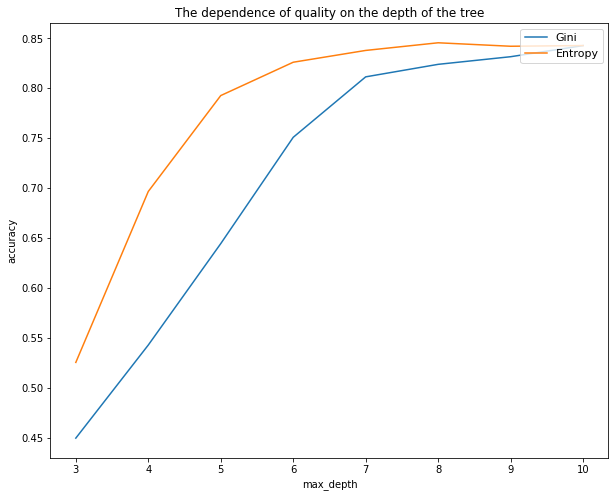

In [23]:
plt.figure(figsize=(10, 8))
plt.title("The dependence of quality on the depth of the tree")
plt.plot(np.arange(3,11), gs.cv_results_['mean_test_score'][:8], label='Gini')
plt.plot(np.arange(3,11), gs.cv_results_['mean_test_score'][8:], label='Entropy')
plt.legend(fontsize=11, loc=1)
plt.xlabel("max_depth")
plt.ylabel('accuracy')
plt.show()

## Regression problem

In [24]:
regr_data = load_boston().data
regr_target = load_boston().target[:, None] # to make the targets consistent with our model interfaces
RX_train, RX_test, Ry_train, Ry_test = train_test_split(regr_data, regr_target, test_size=0.2, random_state=RANDOM_STATE)

In [25]:
regressor = DecisionTree(max_depth=10, criterion_name='mad_median')
regressor.fit(RX_train, Ry_train)
predictions_mad = regressor.predict(RX_test)
mse_mad = mean_squared_error(Ry_test, predictions_mad)
print(mse_mad)

19.84002130725948


In [26]:
regressor = DecisionTree(max_depth=10, criterion_name='variance')
regressor.fit(RX_train, Ry_train)
predictions_mad = regressor.predict(RX_test)
mse_var = mean_squared_error(Ry_test, predictions_mad)
print(mse_var)

9.944881729608415


In [27]:
assert 9 < mse_mad < 20
assert 8 < mse_var < 12

In [28]:
param_grid_R = {'max_depth': range(2,9), 'criterion_name': ['variance', 'mad_median']}

In [29]:
gs_R = GridSearchCV(DecisionTree(), param_grid=param_grid_R, cv=5, scoring='neg_mean_squared_error', n_jobs=-2)
gs_R.fit(RX_train, Ry_train)

GridSearchCV(cv=5, estimator=DecisionTree(), n_jobs=-2,
             param_grid={'criterion_name': ['variance', 'mad_median'],
                         'max_depth': range(2, 9)},
             scoring='neg_mean_squared_error')

In [30]:
gs_R.best_params_

{'criterion_name': 'mad_median', 'max_depth': 5}

In [31]:
assert gs_R.best_params_['criterion_name'] == 'mad_median'
assert 3 < gs_R.best_params_['max_depth'] < 7

In [32]:
var_scores = gs_R.cv_results_['mean_test_score'][:7]
mad_scores = gs_R.cv_results_['mean_test_score'][7:]

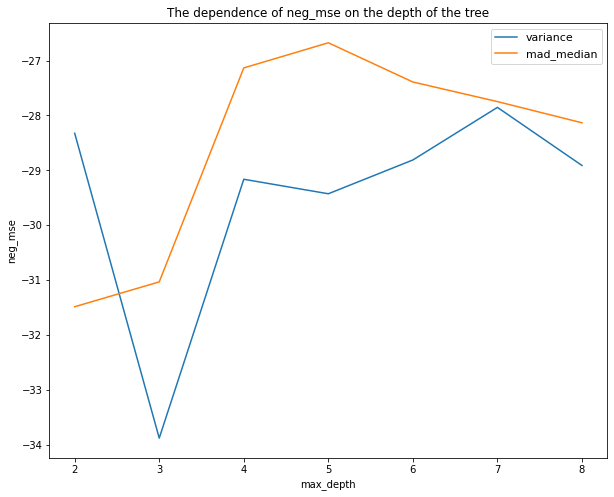

In [33]:
plt.figure(figsize=(10, 8))
plt.title("The dependence of neg_mse on the depth of the tree")
plt.plot(np.arange(2,9), var_scores, label='variance')
plt.plot(np.arange(2,9), mad_scores, label='mad_median')
plt.legend(fontsize=11, loc=1)
plt.xlabel("max_depth")
plt.ylabel('neg_mse')
plt.show()